# Harbour traffic problem
This notebook is developed to address the interference between dredging vessels and container vessels in a certain berth area. Therefore, the berth area is served by both dredging and container vessels.

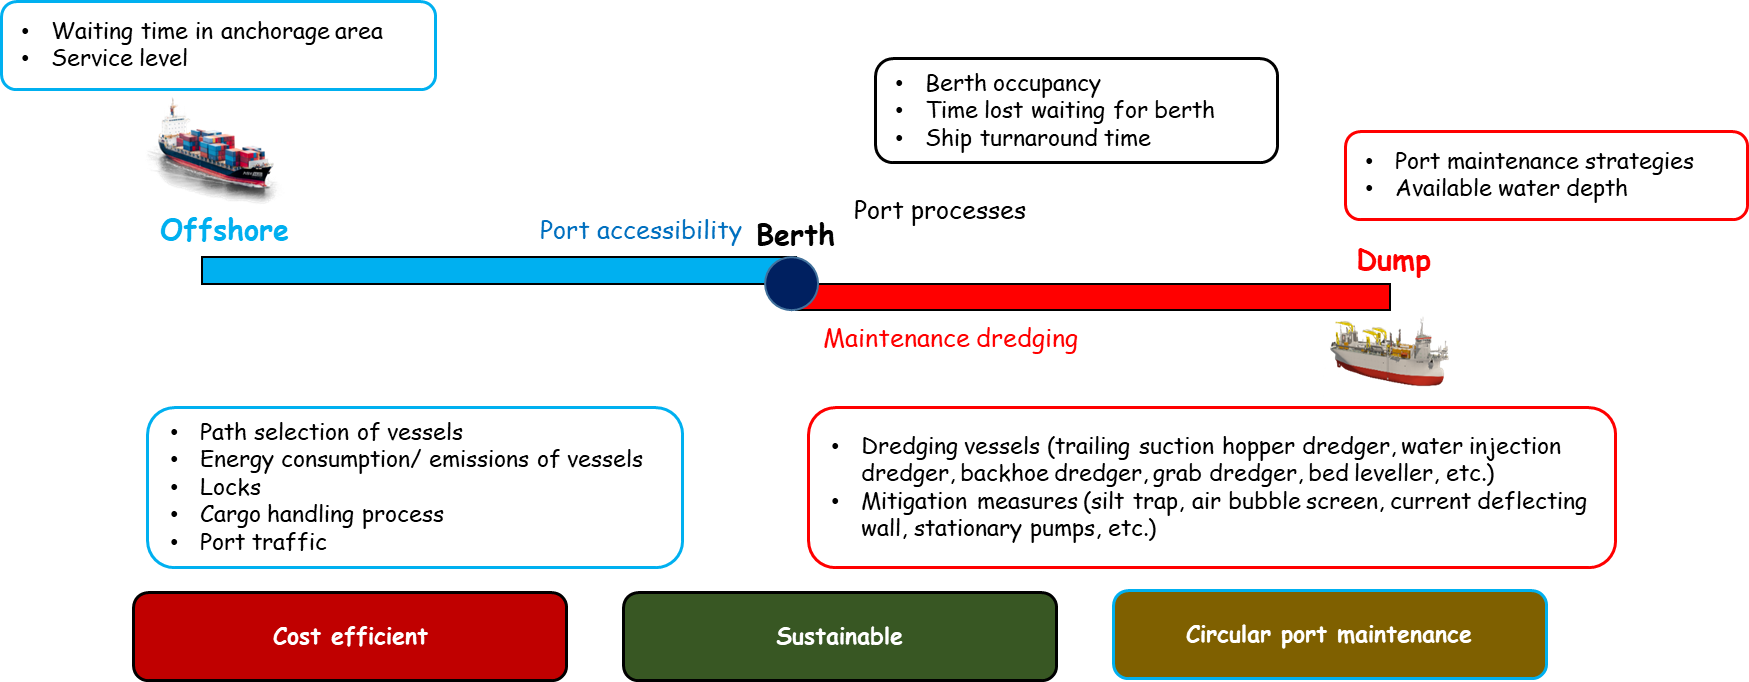

## 0. Imports

We start importing the required libraries.

In [1]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime, time
import simpy
import openclsim
import opentnsim

import pandas as pd

import matplotlib.pyplot as plt
import folium

## 1. Initialize simpy environment

The simpy environment is initialized and a single environment is used for both OpenCLSim and OpenTNSim.

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

### 1.1. Create graph

Number of edges is 4


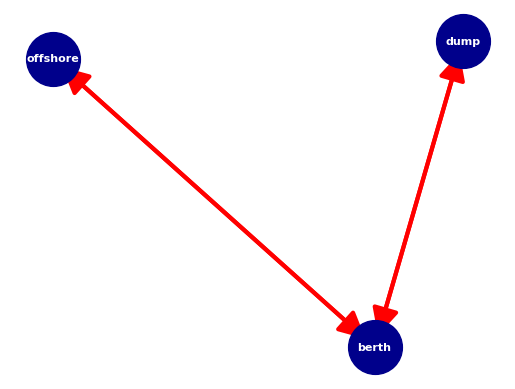

In [3]:
# we start with creating a graph 
graph = nx.DiGraph()

# make your preferred Site class out of available mix-ins which is a combination of mixins from OpenCLSim and OpenTNSim.
Location = type('Site',
            (openclsim.core.Identifiable,
             openclsim.core.Log,
             openclsim.core.Locatable,
             openclsim.core.HasContainer,
             openclsim.core.HasResource,), {})

# three locations (offshore, berth, and dump) are defined to allow the vessels pass the nodes back and forth.
# based on the mixins, more attributes are defined for each location.
locations = []

location_offshore = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
data_offshore = {"env": my_env,
                 "name": "offshore",
                 "geometry": location_offshore,
                 "capacity": 100,
                 "level": 100,
                }
locations.append(Location(**data_offshore))
offshore = Location(**data_offshore)

location_berth = shapely.geometry.Point(4.062705498083785,51.95909715255291)
data_berth = {"env": my_env,
              "name": "berth",
              "geometry": location_berth,
              "capacity": 100,
              "level": 100,
             }
locations.append(Location(**data_berth))
berth = Location(**data_berth)

location_dump = shapely.geometry.Point(4.1795229742823,52.11590591837503)
data_dump = {"env": my_env,
             "name": "dump",
             "geometry": location_dump,
             "capacity": 100,
             "level": 0
            }
locations.append(Location(**data_dump))
dump = Location(**data_dump)   
        
# a graph is initiated based on the name and gemometry of locations.
# other attributes such as store_capacity and initials are not being used for drawing the graph.
for location in locations:
    graph.add_node(location.name,
                geometry = location.geometry)
     
# add edges
path = [[locations[i], locations[i+1]] for i in range(len(locations)-1)]

for index, edge in enumerate(path):
    graph.add_edge(edge[0].name, edge[1].name, weight = 1)
    
# toggle to undirected and back to directed to make sure all edges are two way traffic
graph = graph.to_undirected() 
graph = graph.to_directed()

# create a positions dict for the purpose of plotting
positions = {}
for location in graph.nodes:
    positions[location] = (graph.nodes[location]['geometry'].x, graph.nodes[location]['geometry'].y)
    
# collect node labels.
labels = {}
for location in graph.nodes:
    labels[location] = location
print('Number of edges is {}'.format(len(graph.edges)))

# draw edges, nodes and labels.
nx.draw_networkx_edges(graph,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=40)
nx.draw_networkx_nodes(graph,  pos=positions, node_color="darkblue", node_size=1500)
nx.draw_networkx_labels(graph, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.show()

In [4]:
# add a graph to the environment
my_env.graph = graph

In [5]:
m = folium.Map(location=[52.66, 4.43], zoom_start=8)

folium.Marker(
    [location_dump.y, location_dump.x ], 
    popup="<b>Dump</b>", 
    tooltip="Dump"
).add_to(m)
folium.Marker(
    [location_offshore.y, location_offshore.x ], 
    popup="<b>Offshore</b>", 
    tooltip="Offshore"
).add_to(m)
folium.Marker(
    [location_berth.y, location_berth.x ], 
    popup="<b>Berth</b>", 
    tooltip="Berth"
).add_to(m)

m

## 2. OpenCLSim - dredging process
Derived from:
http://localhost:8888/notebooks/OpenCLSim/notebooks/32_openclsim_opentnsim.ipynb

#### 2.1 Initialise objects

In [6]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource  object based on desired mixin classes
Vessel_obj_01 = type(
    "TransportProcessingResource",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.ContainerDependentMovable,
        openclsim.core.Processor,
        openclsim.core.HasResource,
        openclsim.core.LoadingFunction,
        openclsim.core.UnloadingFunction,
#         # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata
    ),
    {},
)

#### 2.2 Create sites

In [7]:
# example of how to find a location from the list of locations, based on a name 
[i for i, x in enumerate(locations) if x.name == 'offshore'][0]

0

In [8]:
# data from_site
name = "berth"
data_from_site = {
    "env": my_env,
    "name": name,
    "geometry": locations[[i for i, x in enumerate(locations) if x.name == name][0]].geometry,
    "capacity": 100,
    "level": 100
}
# instantiate from_site 
from_site = Site(**data_from_site)

# data to_site
name = "dump"
data_to_site = {
    "env": my_env,
    "name": name,
    "geometry": locations[[i for i, x in enumerate(locations) if x.name == name][0]].geometry,
    "capacity": 100,
    "level": 0
}
# instantiate to_site 
to_site = Site(**data_to_site)

#### 2.3 Create vessels

In [9]:
# prepare input data for vessel_01
start_location = "berth"
data_vessel01 = {
    "env": my_env,
    "name": "dredging vessel",
    "geometry": locations[[i for i, x in enumerate(locations) if x.name == start_location][0]].geometry, 
    "loading_rate": 1,
    "unloading_rate": 5,
    "capacity": 10,
    "compute_v": lambda x: 10 + 2 * x,
#     "v": 10,
#     "route": nx.dijkstra_path(my_env.graph, 'berth', 'dump')
}
# instantiate vessel_01 
vessel01 = Vessel_obj_01(**data_vessel01)
# assert not vessel01.metadata

#### 2.4 Create activities

In [10]:
# create a 'while activity' that contains a pre-packed set of 'sub_processes'
single_run, while_activity  = openclsim.model.single_run_process(
    name="single_run",
    registry={},
    env=my_env,
    origin=berth,
    destination=dump,
    mover=vessel01,
    loader=vessel01,
    unloader=vessel01
)

In [11]:
openclsim.model.register_processes([while_activity])

## 3. OpenTNSim - port process

#### 3.1. Initialise objects

In [12]:
# make your preferred Vessel class out of available mix-ins. 
Vessel_obj_02 = type('Vessel', 
              (opentnsim.core.Identifiable, 
               opentnsim.core.Movable,
               # capture extra metadata to make sure we don't have leftover arguments
               opentnsim.core.ExtraMetadata), {})

#### 3.2. Create vessel

In [13]:
# define a path into and out of the habour
path1 = nx.dijkstra_path(my_env.graph, 'offshore', 'berth')
path2 = nx.dijkstra_path(my_env.graph, 'berth', 'offshore')
path = path1+path2[1:]
display(path)

# prepare input data for vessel_02
start_location = "offshore"
# data_vessel02 = {
#     "env": my_env,
#     "name": "seagoing vessel",
#     "geometry": locations[[i for i, x in enumerate(locations) if x.name == start_location][0]].geometry, 
#     "capacity": 10,
#     "v": lambda x: 10 + 2 * x,
#     "route": path}
    
# create a dict with all important settings
data_vessel02 = {"env": my_env,             # needed for simpy simulation
               "name": 'seagoing vessel',   # required by Identifiable
               "geometry": locations[[i for i, x in enumerate(locations) if x.name == start_location][0]].geometry,      # required by Locatable
               "route": path,               # required by Routeable
               "v": 1}                      # required by Movable

# instantiate vessel_02 
vessel02 = Vessel_obj_02(**data_vessel02)
assert not vessel02.metadata

['offshore', 'berth', 'offshore']

#### 3.3. Create the vessel activity

In [14]:
# specify the process that needs to be executed
my_env.process(vessel02.move())

<Process(move) object at 0x1759b58da90>

### 4, Run the simulation
Will execute all prepared activities (as specified in 2.4 (OpenCLSim) and 3.3 (OpenTNSim))

In [15]:
# start the simulation
my_env.run()

### 5. Inspect the results

#### 5.1 The OpenCLSim components

In [16]:
display(openclsim.plot.get_log_dataframe(vessel01, [*single_run, while_activity]))

,Activity,Timestamp,ActivityState,geometry,container level
0,single_run sailing empty,1970-01-01 00:00:00.000000,START,POINT (4.062705498083785 51.95909715255291),0.0
1,single_run sailing empty,1970-01-01 00:00:00.000000,STOP,POINT (4.062705498083785 51.95909715255291),0.0
2,single_run loading,1970-01-01 00:00:00.000000,START,POINT (4.062705498083785 51.95909715255291),0.0
3,single_run loading,1970-01-01 00:00:10.000000,STOP,POINT (4.062705498083785 51.95909715255291),10.0
4,single_run sailing filled,1970-01-01 00:00:10.000000,START,POINT (4.062705498083785 51.95909715255291),10.0
...,...,...,...,...,...
75,single_run loading,1970-01-01 08:49:59.864804,STOP,POINT (4.062705498083785 51.95909715255291),10.0
76,single_run sailing filled,1970-01-01 08:49:59.864804,START,POINT (4.062705498083785 51.95909715255291),10.0
77,single_run sailing filled,1970-01-01 09:16:39.958986,STOP,POINT (4.1795229742823 52.11590591837503),10.0
78,single_run unloading,1970-01-01 09:16:39.958986,START,POINT (4.1795229742823 52.11590591837503),10.0


In [17]:
openclsim.plot.get_gantt_chart([while_activity, vessel01, *single_run])

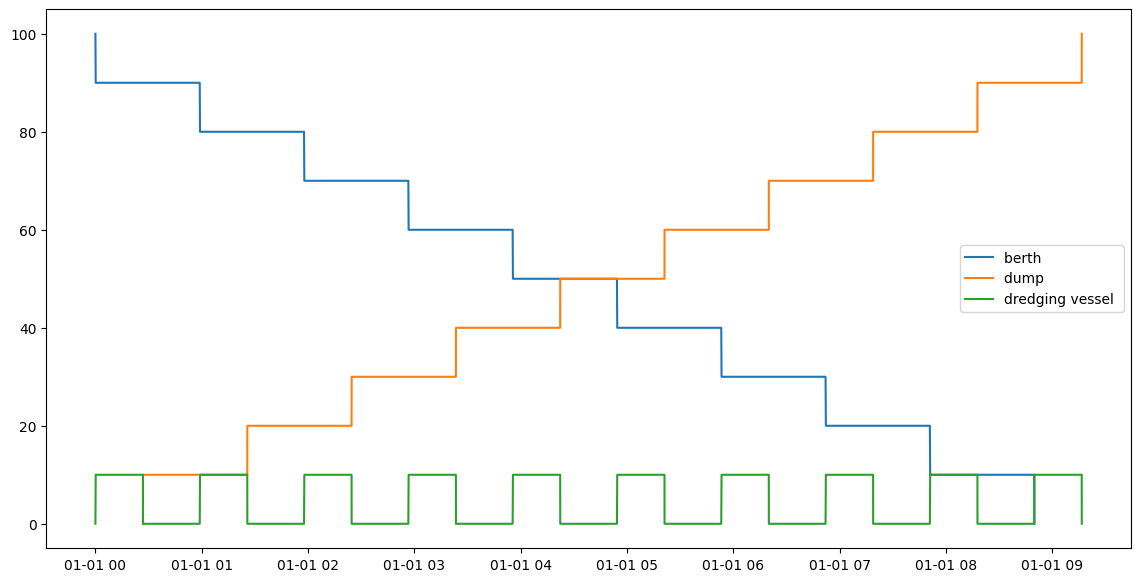

In [18]:
fig = openclsim.plot.get_step_chart([berth, dump, vessel01])

#### 5.1 The OpenTNSim components

In [19]:
vessel02.log

{'Message': ['Sailing from node offshore to node berth start',
  'Sailing from node offshore to node berth stop',
  'Sailing from node berth to node offshore start',
  'Sailing from node berth to node offshore stop'],
 'Timestamp': [datetime.datetime(1970, 1, 1, 1, 0),
  datetime.datetime(1970, 1, 1, 10, 18, 15, 594056),
  datetime.datetime(1970, 1, 1, 10, 18, 15, 594056),
  datetime.datetime(1970, 1, 1, 19, 36, 31, 188113)],
 'Value': [0, 0, 0, 0],
 'Geometry': [<POINT (3.638 52.107)>,
  <POINT (4.063 51.959)>,
  <POINT (4.063 51.959)>,
  <POINT (3.638 52.107)>]}

In [20]:
# note the slightly different log handling than for the openclsim elemnents
df = pd.DataFrame.from_dict(vessel02.log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node offshore to node berth start,1970-01-01 01:00:00.000000,0,POINT (3.637610458072877 52.10701582514347)
1,Sailing from node offshore to node berth stop,1970-01-01 10:18:15.594056,0,POINT (4.062705498083785 51.95909715255291)
2,Sailing from node berth to node offshore start,1970-01-01 10:18:15.594056,0,POINT (4.062705498083785 51.95909715255291)
3,Sailing from node berth to node offshore stop,1970-01-01 19:36:31.188113,0,POINT (3.637610458072877 52.10701582514347)
